# How to create and visualize a Landlab Icosphere Grid

*(GE Tucker, CU Boulder, November 2023)*

This notebook demonstrates how to create a spherical `IcosphereGlobalGrid`, and to visualize its geometric elements and related fields.

## About IcosphereGlobal grid

`IcosphereGlobalGrid` represents a spherical surface as an *icosphere*, also known as a *geodesic polyhedron*: a convex polyhedron made of triangular faces. The icosphere allows a relatively even distribution of points across the surface, as compared with a latitude-longitude grid, in which points bunch together around the poles.

The process of creating an `IcosphereGlobalGrid` starts with an *icosahedron* (a 20-sided polyhedron with 12 vertices). The initial icosahedron is then refined by iteratively subdividing each triangle into four smaller triangles. The user of `IcosphereGlobalGrid` specifies how many iterative levels of subdivision are applied, using the parameter `mesh_densification_level`.

An icosphere has the useful characteristic of having a dual geometry. The dual geometry for an icosahedron is a dodecahedron (12-sided polyhedron with 20 vertices). More generally, at any level of subdivision, an icosphere's triangular patches and their vertices have a matching Goldberg Polyhedron, in which each triangle vertex lies within a corresponding pentagonal or (if densification level >0) hexagonal polygon. 

In a Landlab `IcosphereGlobalGrid`, the icosphere comprises triangular *patches* with *nodes* as vertices and *links* as edges. The corresponding Goldberg Polyhedron is composed of pentagonal and hexagonal *cells* with *corners* as vertices and *faces* as the edges of the pentagons and hexagons.

Unlike the various 2D grid types, the nodes and corners in an IcosphereGlobalGrid have a $z$ coordinate in addition to their $x$ and $y$ coordinates. The grid also provides the corresponding spherical coordinates $r$, $\phi$, and $\theta$ ($r$ being radial distance from the center of the sphere, $\phi$ the longitude, and $\theta$ the latitude angle measured from zero at the "south" pole (so the equator lies at $\theta = \pi/2$ and the north pole lies at $\theta = \pi$).

## Creating an IcosphereGlobalGrid

The following examples illustrate how to create an `IcosphereGlobalGrid`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import IcosphereGlobalGrid

In [11]:
def plot_ico_grid(vtx_coords, verts_at_line, cmap="Blues", title=None):
    """Plot vertex and line elements of an icosphere grid."""
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.set_title(title)

    val_for_vertex_color = 0.25 * (vtx_coords[:, 0] + 1) + 0.25 * (1 - vtx_coords[:, 1])
    val_for_line_color = 0.25 * (1 - vtx_coords[verts_at_line[:, 0], 1]) + 0.25 * (
        1 + vtx_coords[verts_at_line[:, 0], 0]
    )

    ax.scatter(
        vtx_coords[:, 0],
        vtx_coords[:, 1],
        vtx_coords[:, 2],
        c=val_for_vertex_color,
        cmap=cmap,
    )

    for i in range(grid.number_of_links):
        ax.plot(
            vtx_coords[verts_at_line[i, :], 0],
            vtx_coords[verts_at_line[i, :], 1],
            vtx_coords[verts_at_line[i, :], 2],
            "k",
            alpha=val_for_line_color[i],
        )
        
    ax.axis("equal")

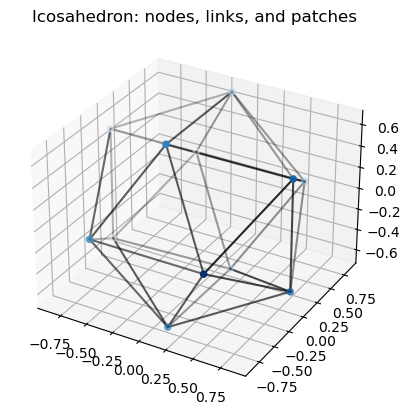

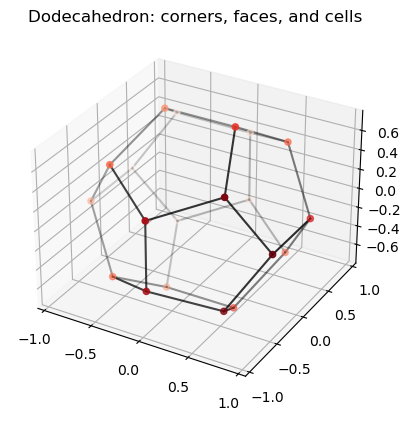

In [12]:
# No densification: icosahedron and dodecahedron
grid = IcosphereGlobalGrid()

# Icosahedron: nodes, patches, and links
plot_ico_grid(
    grid.coords_of_node,
    grid.nodes_at_link,
    cmap="Blues",
    title="Icosahedron: nodes, links, and patches",
)

# Dodecahedron: corners, cells, and faces
plot_ico_grid(
    grid.coords_of_corner,
    grid.corners_at_face,
    cmap="Reds",
    title="Dodecahedron: corners, faces, and cells",
)


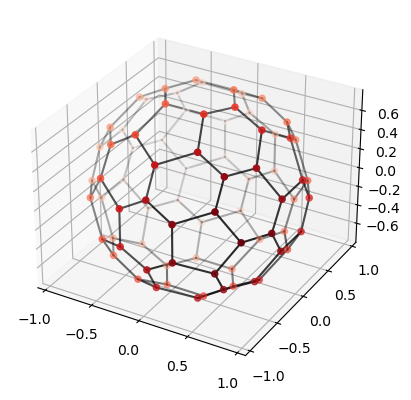

In [13]:
# Densification level 1: soccer ball
grid = IcosphereGlobalGrid(radius=1.0, mesh_densification_level=1)

plot_ico_grid(grid.coords_of_corner, grid.corners_at_face, cmap="Reds")

## Adding fields

Fields can be added using the same functions that are used with any other type of grid. The example below creates a grid and adds a node field called `latitude`, to which is assigned the latitude values in degrees. The example also illustrates the use of the `radius` parameter.

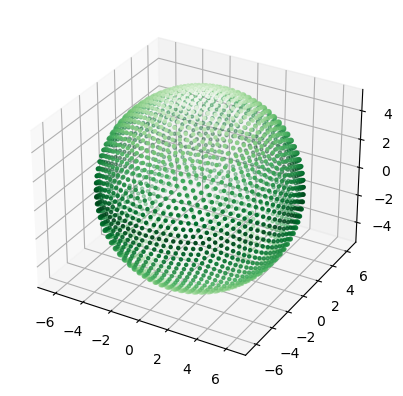

In [28]:
grid = IcosphereGlobalGrid(radius=6.37e6, mesh_densification_level=4)

lat = grid.add_zeros("latitude", at="node")
lat[:] = np.abs(np.degrees(grid.theta_of_node) - 90.0)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(
    grid.x_of_node,
    grid.y_of_node,
    grid.z_of_node,
    c=(90.0 - lat),
    cmap="Greens",
    s=5,
)

_ = ax.axis("equal")

## Saving output for external 3D visualization